In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
##########################################
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import make_2dgaussian_kernel, detect_sources
from astropy.convolution import convolve
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [28]:
data_path = '../data/'
fitsfile = data_path + 'hlsp_fresco_hst_acs-wfc_goods-s_f435w_v1.0_sci.fits'
fitsfile = 'anshu_gal210w.fits'

In [29]:
f = fits.open(fitsfile)
data = f[0].data
wcs = WCS(f[0])

In [30]:
pix00=0
pix01=1000
pix10 = 0
pix11 = 1000
data = data#[pix00:pix01, pix10:pix11]
wcs =  wcs #[pix00:pix01, pix10:pix11]

In [31]:
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data_sub = data - bkg.background  # subtract the background
threshold = 1.5 * bkg.background_rms
kernel = make_2dgaussian_kernel(2.0, size=3)  # FWHM = 3.0
convolved_data = convolve(data_sub, kernel)
segment_map = detect_sources(convolved_data, threshold, npixels=10)

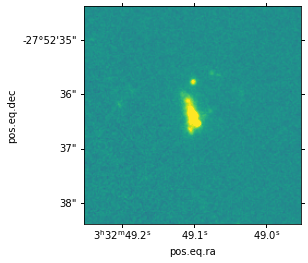

In [32]:
plt.subplot(111, projection=wcs)
plt.imshow(data_sub, origin='lower', vmax=0.1, vmin=-0.1)


In [33]:
bkg.background

array([[-2.5884094e-04, -2.5884094e-04, -2.5884094e-04, ...,
        -5.8632239e-05, -5.8566082e-05, -5.8533005e-05],
       [-2.5884094e-04, -2.5884094e-04, -2.5884094e-04, ...,
        -5.8574940e-05, -5.8508864e-05, -5.8475824e-05],
       [-2.5884094e-04, -2.5884094e-04, -2.5884094e-04, ...,
        -5.8460344e-05, -5.8394420e-05, -5.8361456e-05],
       ...,
       [ 4.0761119e-04,  4.0772525e-04,  4.0795337e-04, ...,
         2.2163334e-04,  2.2144061e-04,  2.2134423e-04],
       [ 4.0752339e-04,  4.0763750e-04,  4.0786577e-04, ...,
         2.2165000e-04,  2.2145765e-04,  2.2136146e-04],
       [ 4.0747947e-04,  4.0759364e-04,  4.0782196e-04, ...,
         2.2165834e-04,  2.2146617e-04,  2.2137008e-04]], dtype=float32)

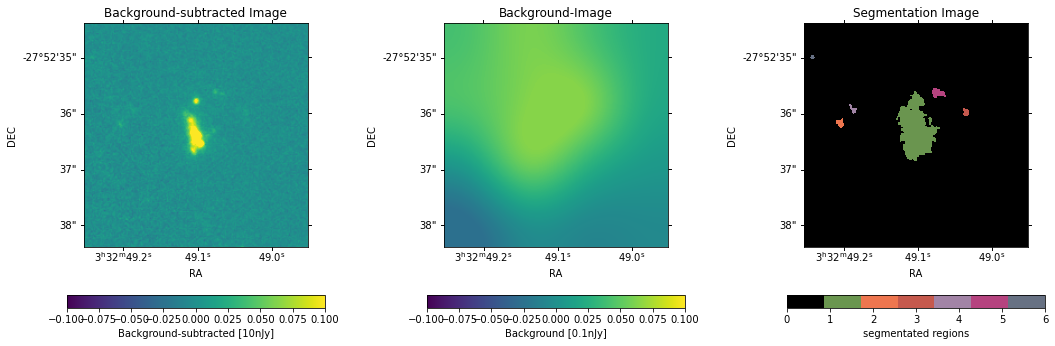

In [60]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # Corrected import
from astropy.wcs import WCS

# Create figure and subplots with WCS projections
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': wcs[pix0:pix1, pix0:pix1]})

# Plot background-subtracted data
im1 = ax1.imshow(data_sub, origin='lower' , vmax=0.1, vmin=-0.1)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
cbar = fig.colorbar(im1, ax=ax1, label='Background-subtracted [10nJy]', orientation='horizontal')
ax1.set_title('Background-subtracted Image')

im2 = ax2.imshow(bkg.background*100, origin='lower' , vmax=0.1, vmin=-0.1)
ax2.set_title('Background-Image')
ax2.set_xlabel('RA', )
ax2.set_ylabel('DEC', )
# Add a colorbar to ax2
cbar = fig.colorbar(im2, ax=ax2, label='Background [0.1nJy]', orientation='horizontal')
# Plot segmentation map with nearest interpolation and LogNorm
im3 = ax3.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
cbar = fig.colorbar(im3, ax=ax3, label='segmentated regions' , orientation='horizontal')
ax3.set_title('Segmentation Image')
ax3.set_xlabel('RA')
ax3.set_ylabel('DEC', )
# Show the plot
plt.tight_layout()
plt.show()


In [61]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)

In [62]:
segm_deblend.segments

[<photutils.segmentation.core.Segment>
 label: 1
 slices: (slice(106, 115, None), slice(29, 36, None))
 area: 40,
 <photutils.segmentation.core.Segment>
 label: 2
 slices: (slice(117, 124, None), slice(142, 147, None))
 area: 28,
 <photutils.segmentation.core.Segment>
 label: 3
 slices: (slice(119, 128, None), slice(40, 47, None))
 area: 27,
 <photutils.segmentation.core.Segment>
 label: 4
 slices: (slice(133, 142, None), slice(114, 127, None))
 area: 72,
 <photutils.segmentation.core.Segment>
 label: 5
 slices: (slice(168, 171, None), slice(5, 10, None))
 area: 11,
 <photutils.segmentation.core.Segment>
 label: 6
 slices: (slice(77, 126, None), slice(82, 118, None))
 area: 1061,
 <photutils.segmentation.core.Segment>
 label: 7
 slices: (slice(100, 116, None), slice(111, 121, None))
 area: 59,
 <photutils.segmentation.core.Segment>
 label: 8
 slices: (slice(122, 139, None), slice(92, 108, None))
 area: 167]

Text(0.5, 1.0, 'Deblended Segmentation Image')

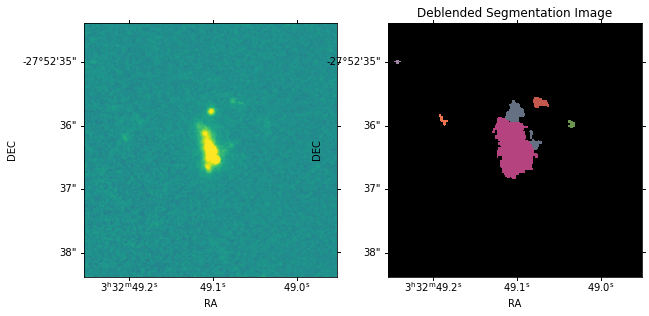

In [68]:
#norm = ImageNormalize(stretch=SqrtStretch())
pix0=0
pix1=1000
norm = simple_norm(data_sub[pix0:pix1, pix0:pix1], 'sqrt')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': wcs[pix0:pix1, pix0:pix1]})
ax1.imshow(data_sub[pix0:pix1, pix0:pix1], origin='lower',  vmax=0.1, vmin=-0.1)

ax2.imshow(segm_deblend[pix0:pix1, pix0:pix1], origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax1.set_xlabel('RA', )
ax1.set_ylabel('DEC', )
ax2.set_xlabel('RA', )
ax2.set_ylabel('DEC', )
ax2.set_title('Deblended Segmentation Image')

In [69]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (200, 200)
nlabels: 8
labels: [1 2 3 4 5 6 7 8]


In [70]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data_sub, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 8
labels: [1 2 3 4 5 6 7 8]


In [71]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1     32.14    109.58 ...             nan      1.14          nan
    2    143.96    119.81 ...             nan      0.85          nan
    3     43.00    122.81 ...             nan      0.63          nan
    4    118.76    137.18 ...             nan      2.18          nan
    5      6.95    169.01 ...             nan      0.18          nan
    6     98.94     99.46 ...             nan     55.61          nan
    7    114.93    104.93 ...             nan      2.55          nan
    8     99.49    129.45 ...             nan      6.00          nan


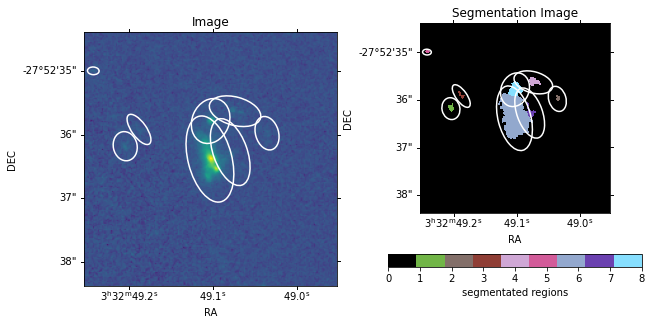

In [77]:
norm = simple_norm(data_sub[pix0:pix1, pix0:pix1], 'sqrt')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': wcs[pix0:pix1, pix0:pix1]})
ax1.imshow(data_sub[pix0:pix1, pix0:pix1], origin='lower', norm=norm)
ax1.set_title('Image')
im3 = ax2.imshow(segm_deblend[pix0:pix1, pix0:pix1], origin='lower', cmap=segm_deblend.cmap,
           interpolation='nearest')
cbar = fig.colorbar(im3, ax=ax2, label='segmentated regions' , orientation='horizontal')
ax2.set_title('Segmentation Image')
ax1.set_xlabel('RA', )
ax1.set_ylabel('DEC', )
ax2.set_xlabel('RA', )
ax2.set_ylabel('DEC', )
cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5)

In [ ]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data_sub, threshold=0.1)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl)

In [ ]:
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))  

In [ ]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  

In [ ]:
from astropy.nddata import NDData
nddata = NDData(data=data_sub, wcs=wcs)  

In [ ]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)  

In [ ]:
plt.subplot(111, projection=wcs)
plt.imshow(stars[0])


In [ ]:
cat = SourceCatalog(data_sub, segm_deblend, convolved_data=convolved_data)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
tbl2 = cat_subset.to_table()
tbl2['xcentroid'].info.format = '.2f'  # optional format
tbl2['ycentroid'].info.format = '.2f'
tbl2['kron_flux'].info.format = '.2f'
print(tbl2)

In [ ]:
cat = SourceCatalog(data_sub, segm_deblend, convolved_data=convolved_data)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux']
tbl3 = cat_subset.to_table(columns=columns)
tbl3['xcentroid'].info.format = '.4f'  # optional format
tbl3['ycentroid'].info.format = '.4f'
tbl3['segment_flux'].info.format = '.4f'
print(tbl3)

In [ ]:
cat = SourceCatalog(data_sub, segm_deblend, background=bkg.background)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
columns = ['label', 'background_centroid', 'background_mean',
           'background_sum']
tbl4 = cat_subset.to_table(columns=columns)
tbl4['background_centroid'].info.format = '{:.10f}'  # optional format
tbl4['background_mean'].info.format = '{:.10f}'
tbl4['background_sum'].info.format = '{:.10f}'
print(tbl4)

In [ ]:
norm = simple_norm(bkg.background[pix0:pix1, pix0:pix1], 'sqrt')
plt.imshow(bkg.background[pix0:pix1, pix0:pix1], norm = norm)
plt.colorbar()

In [ ]:
norm = simple_norm(data_sub[pix0:pix1, pix0:pix1], 'sqrt')
plt.imshow(data_sub[pix0:pix1, pix0:pix1], norm = norm)
plt.colorbar()

In [ ]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data_sub[pix0:pix1, pix0:pix1], (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [ ]:
plt.imshow(bkg.background, origin='lower', 
           interpolation='nearest',  vmin=-0.001, vmax=0.001,)

In [ ]:
norm = ImageNormalize(stretch=SqrtStretch())  
#norm = simple_norm(data_sub[pix0:pix1, pix0:pix1] - bkg.background, 'sqrt')
plt.imshow(data_sub[pix0:pix1, pix0:pix1] - bkg.background, norm=norm, origin='lower',
         interpolation='nearest')

In [ ]:
plt.imshow(data_sub[pix0:pix1, pix0:pix1], origin='lower', cmap='Greys_r', norm=norm,
           interpolation='nearest')
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3)
plt.xlim(0, 250)
plt.ylim(0, 250)

In [ ]:
import numpy as np
from photutils.centroids import centroid_2dg, centroid_sources

data2 = data_sub[pix0:pix1, pix0:pix1]- np.median(data_sub[pix0:pix1, pix0:pix1])
x_init = (25, 91, 151, 160)
y_init = (40, 61, 24, 71)
x, y = centroid_sources(data2, x_init, y_init, box_size=25,
                        centroid_func=centroid_2dg)
print(x)  
print(y)  

In [ ]:
plt.imshow(data_sub[pix0:pix1, pix0:pix1], origin='lower',  vmin=-0.1, vmax=0.1,
           interpolation='nearest')
plt.plot(x, y, 'P', color='red')

In [ ]:
x, y

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [ ]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)  